# Atividade 2 - CIS

Está atividade tem como objetivo principal implementar um knn para obter informações de um dataset de vinhos. Em seguida foi utilizado o algoritmo de random forest para poder ter uma comparação entre os dois.

# Preparando o Ambiente

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from collections import Counter
from imblearn.over_sampling import SMOTE

In [6]:
df = pd.read_csv('/kaggle/input/winequality/winequality.csv')

Plotando os histogramas para entender como está a distribuição do dado.

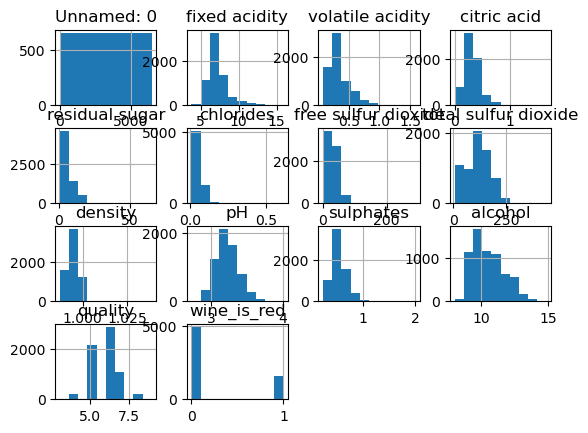

In [8]:
df.hist();

In [9]:
df.corr()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
Unnamed: 0,1.000000,-0.005802,-0.006563,0.001267,0.009281,0.004900,0.010895,0.014595,0.006579,-0.016673,0.004192,0.000113,-0.000376,-0.002214
fixed acidity,-0.005802,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,0.486740
volatile acidity,-0.006563,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,0.653036
citric acid,0.001267,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,-0.187397
residual sugar,0.009281,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,-0.348821
chlorides,0.004900,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,0.512678
free sulfur dioxide,0.010895,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,-0.471644
total sulfur dioxide,0.014595,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,-0.700357
density,0.006579,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,0.390645
pH,-0.016673,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,0.329129


Removendo a coluna 'Unnamed: 0' que era o id no csv 

In [10]:
df = df.drop('Unnamed: 0', axis=1)

# Definindo o dataset de treino e validação

Inicialmente eu dividi o dataset em treino e validação, para poder avaliar o resultado do algoritmo de knn.

In [5]:
trn_df,val_df = train_test_split(df, test_size=0.25)

Criei o dataframe chamado target para armazenar os valores esperados de cada amostra

In [6]:
target = df['wine_is_red']

In [7]:
target_trn = trn_df['wine_is_red']
trn_df = trn_df.drop('wine_is_red', axis=1)

In [8]:
target_val = val_df['wine_is_red']
val_df = val_df.drop('wine_is_red', axis=1)

# knn

O K-Nearest Neighbors busca identificar as amostras mais parecidas com o dado passado para ele, para verificar essa semelhança ele utiliza a distancia euclidiana. Depois ele pega os k elementos mais próximos, verifica a classificação deles e com base nesse dado ele defini a classificação do dado passado. A métrica usada foi a accuracy

In [48]:
def knn(data, points, target, k):
    dimensions = data.shape[1]
    size = len(points)
    result = pd.DataFrame(columns=['id', 'wine_is_red', 'real_value'])
    for j in range(size):
        dist = (data - points.iloc[j])**2
        dist = dist.sum(axis=1)**(1/2)
        dist = dist.sort_values()
        dist = dist.index.tolist()
        wine_type = []
        for i in range(k):
            wine_type.append(target.iloc[dist[i]])
        wine_type = np.mean(wine_type).round()
        val = wine_type == target.iloc[points.iloc[j].name]
        result.loc[len(result), ['id', 'wine_is_red','real_value']] = points.iloc[j].name, wine_type, val
    
    accuracy = len(result[result['real_value'] == True]) / size
    print(f'Accuracy: {accuracy}')
    
    return result

In [12]:
result = knn(trn_df, val_df, target, 3)

Accuracy: 0.9446153846153846


O algoritmo retorna um df com as previsões e com a comparação com o valor esperado 'real_value'

In [13]:
result

,id,wine_is_red,real_value
0,2855,0.0,True
1,2543,0.0,True
2,3158,0.0,True
3,1070,0.0,True
4,1555,0.0,True
...,...,...,...
1620,5217,0.0,True
1621,128,0.0,True
1622,5715,0.0,True
1623,6322,0.0,True


# Decision Tree


Agora eu apliquei o algoritmo de decision tree para compara com o knn.

In [14]:
m = DecisionTreeClassifier(max_depth = 3 ).fit(trn_df, target_trn);

Em seguida foi verificado a feature importance do modelo.

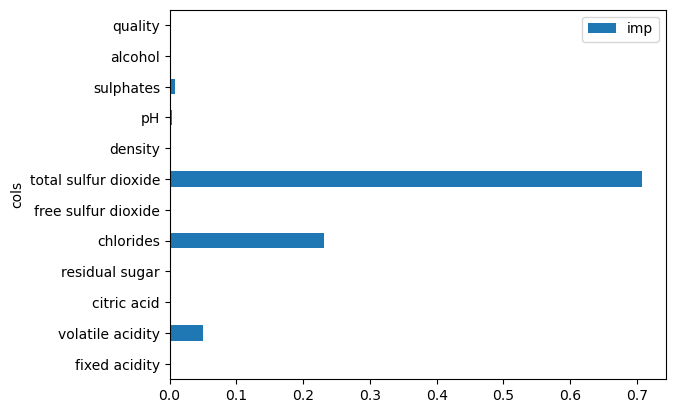

In [15]:
pd.DataFrame(dict(cols=trn_df.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

A métrica usada para calcular a precisão do modelo foi o r2_score, ele retorna valores entre 0 e 1. Onde 1 é o melhor resultado e 0 é o pior.

In [16]:
r2_score(target_val, m.predict(val_df))

0.8230371247051474

# Random Forest

Aplicando o modelo de random forest para ver se o resultado melhora.

In [17]:
m = RandomForestClassifier(min_samples_leaf=5).fit(trn_df, target_trn);

A feature importance desse modelo considerou bem mais caraterísticas do que o outro.

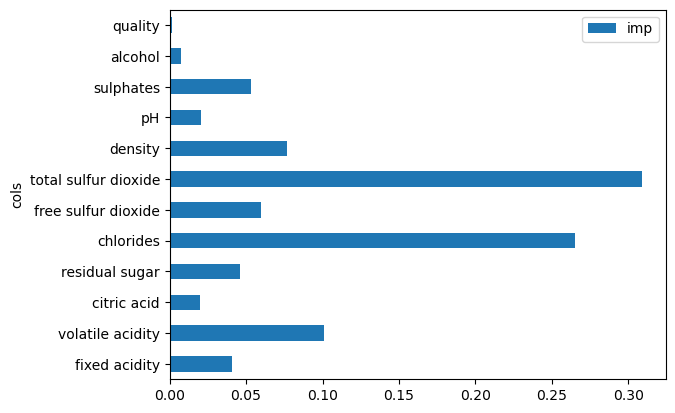

In [23]:
pd.DataFrame(dict(cols=trn_df.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

Usando a métrica R2 o resultado melhorou bastante.

In [18]:
r2_score(target_val, m.predict(val_df))

0.9365604786678831

# Classificador de qualidade

Agora mudamos o problema de uma classificação binária para uma classificação multiclasse

In [19]:
trn_x,val_x = train_test_split(df, test_size=0.25)

target = df['quality']
data_x = df.drop('quality', axis=1)
trn_y = trn_x['quality']
val_y = val_x['quality']
trn_x = trn_x.drop('quality', axis=1)
val_x = val_x.drop('quality', axis=1)

In [26]:
m = RandomForestClassifier(min_samples_leaf=5).fit(trn_x, trn_y);

O desempenho do modelo foi consideravelmente pior que o classificador binário

In [27]:
r2_score(val_y, m.predict(val_x))

0.3397491914671197

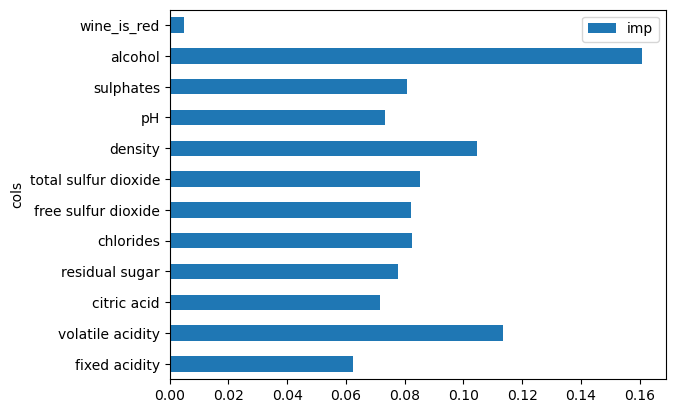

In [28]:
pd.DataFrame(dict(cols=trn_x.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

Testando esse problema no algoritmo de knn criado anteriormente.

In [50]:
result = knn(trn_x, val_x, target, 3)

Accuracy: 0.4867692307692308


# Aplicando o OverSampling

O oversampling cria novas amostras com base nas que já existem, essa técnica pode fazer com que os modelos obtenham melhores resultados.

In [20]:
data_x = data_x.values
target = target.values

In [35]:
smote = SMOTE(random_state=42, k_neighbors=1)

X_smote, y_smote = smote.fit_resample(data_x, target)

In [42]:
# A quantidade de cada amostra fica igual
qnt_valores = Counter(y_smote)
qnt_valores

Counter({6: 2836, 7: 2836, 5: 2836, 4: 2836, 8: 2836, 3: 2836, 9: 2836})


Separando o novo dado para realizar os testes

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [44]:
m = RandomForestClassifier(min_samples_leaf=5).fit(X_train, y_train);

Usando uma random forest com os mesmos parâmetros o resultado melhorou bastante, indo de 0.33 para 0.95

In [45]:
r2_score(y_test, m.predict(X_test))

0.9529539103447181

# Conclusão

Para a classificação binário não foi necessário gerar mais dados, pois se tratava de um problema relativamente simples. Já na classificação da qualidade do vinho foi necessário gerar mais dados para melhorar o resultado, pois o dado não estava bem dividido e algumas classes possuíam poucas amostras.